In [1]:
# 필수 Package import
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import torchvision.models as models





In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
def display_images(image_paths, title, max_images=6):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[:max_images]):
        img = plt.imread(path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    


Train damage 총 이미지 수: 5900


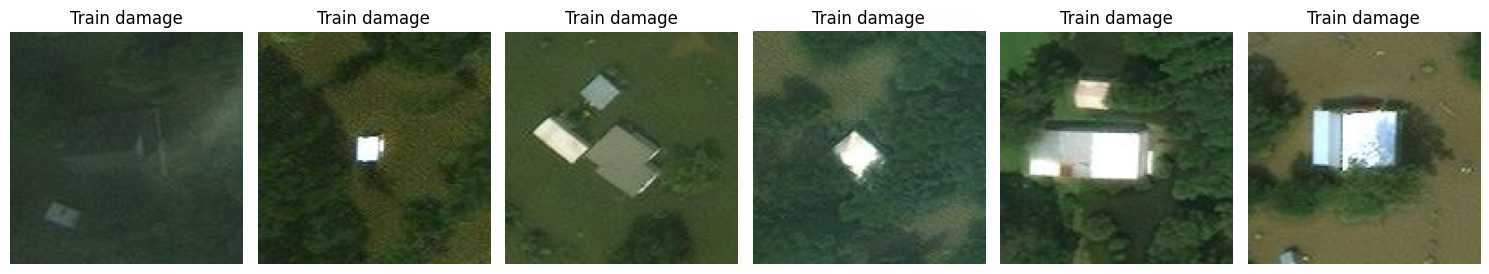

Train normal 총 이미지 수: 5901


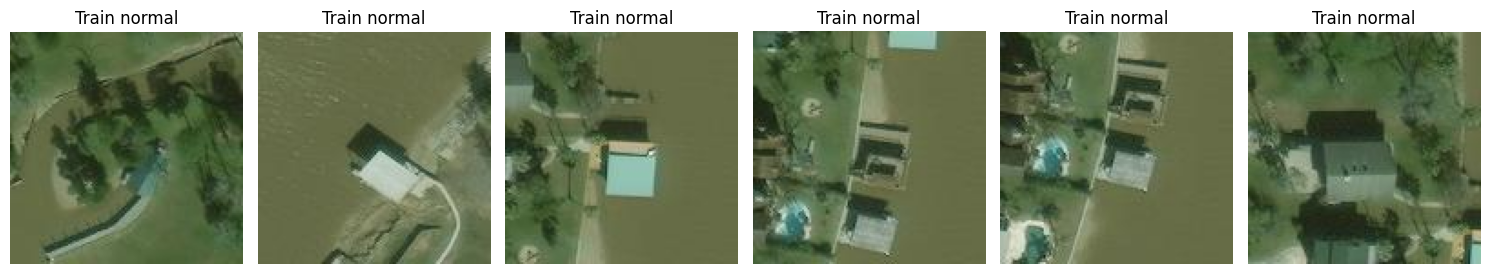

Val damage 총 이미지 수: 1000


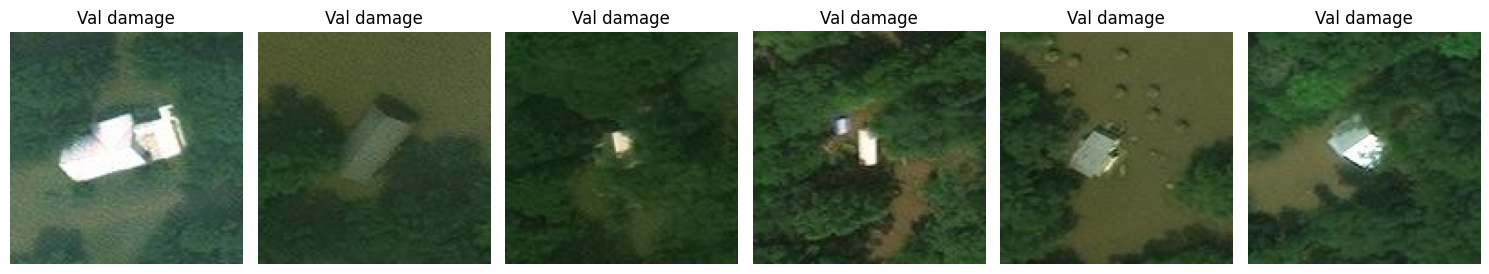

Val normal 총 이미지 수: 1000


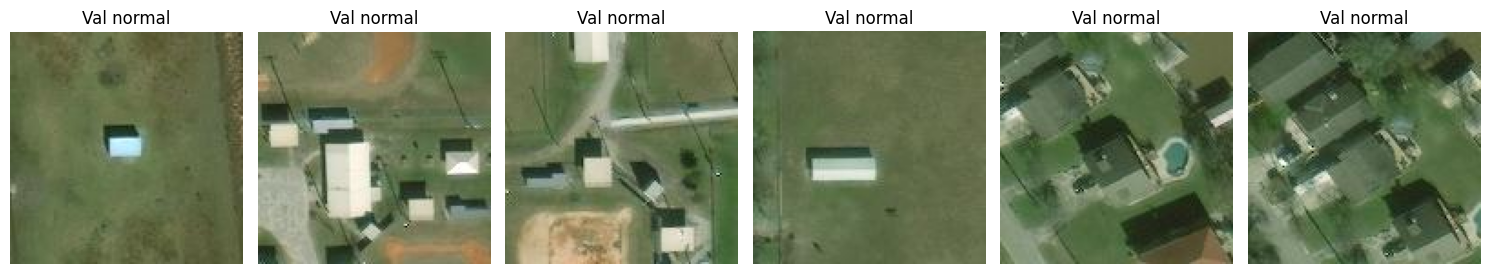

Test damage 총 이미지 수: 100


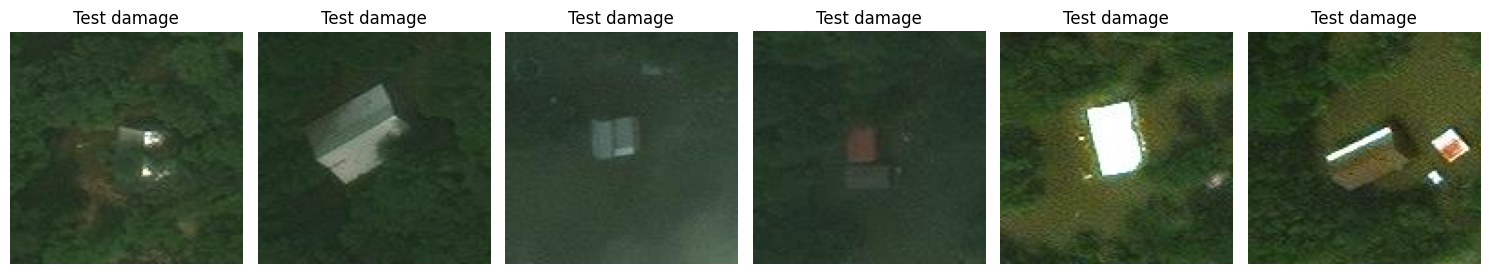

Test normal 총 이미지 수: 100


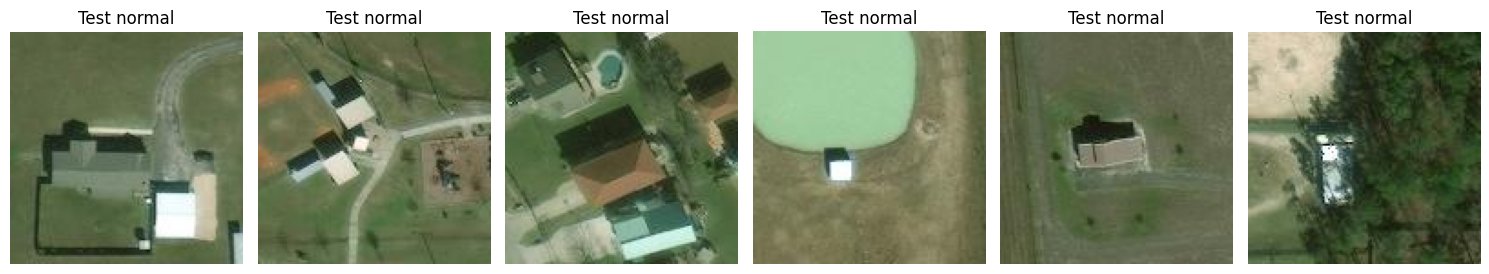

In [5]:
categories = ['Train damage', 'Train normal', 'Val damage', 'Val normal', 'Test damage', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/9/{category.lower().replace(" ", "/")}/*')
    print(f'{category} 총 이미지 수: {len(image_paths)}')
    display_images(image_paths, [category]*len(image_paths))
    


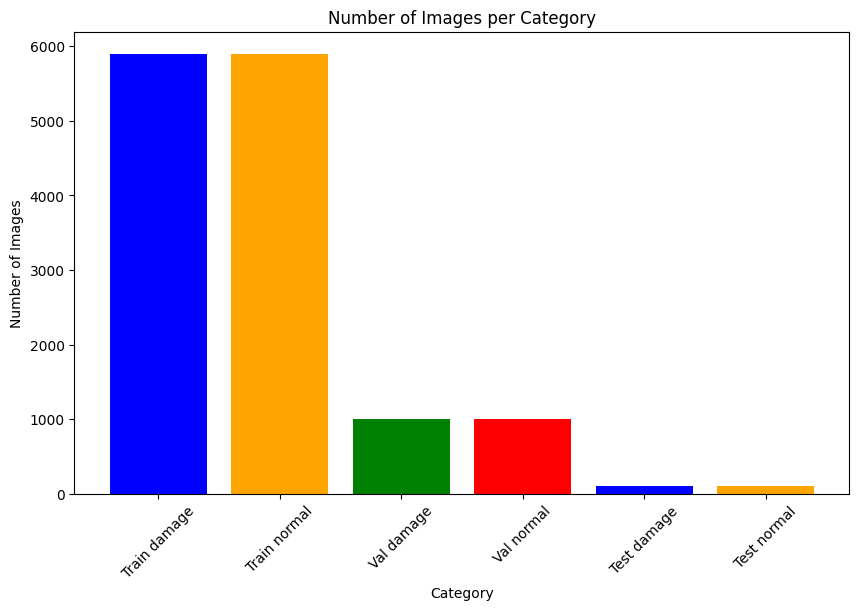

In [6]:
# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'../실습 파일/9/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [7]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.LinearContrast((0.75, 1.5)),  # 대비 조절
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Flipud(0.2),  # 20% 확률로 상하 반전
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [8]:
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [9]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms

pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
# 데이터셋 및 데이터 로더 초기화
train_path = '../실습 파일/9/train'
val_path = '../실습 파일/9/val'

train_dataset = CustomDataset(train_path, imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset(val_path, imgaug=None, transform=pytorch_transforms)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True)







In [14]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

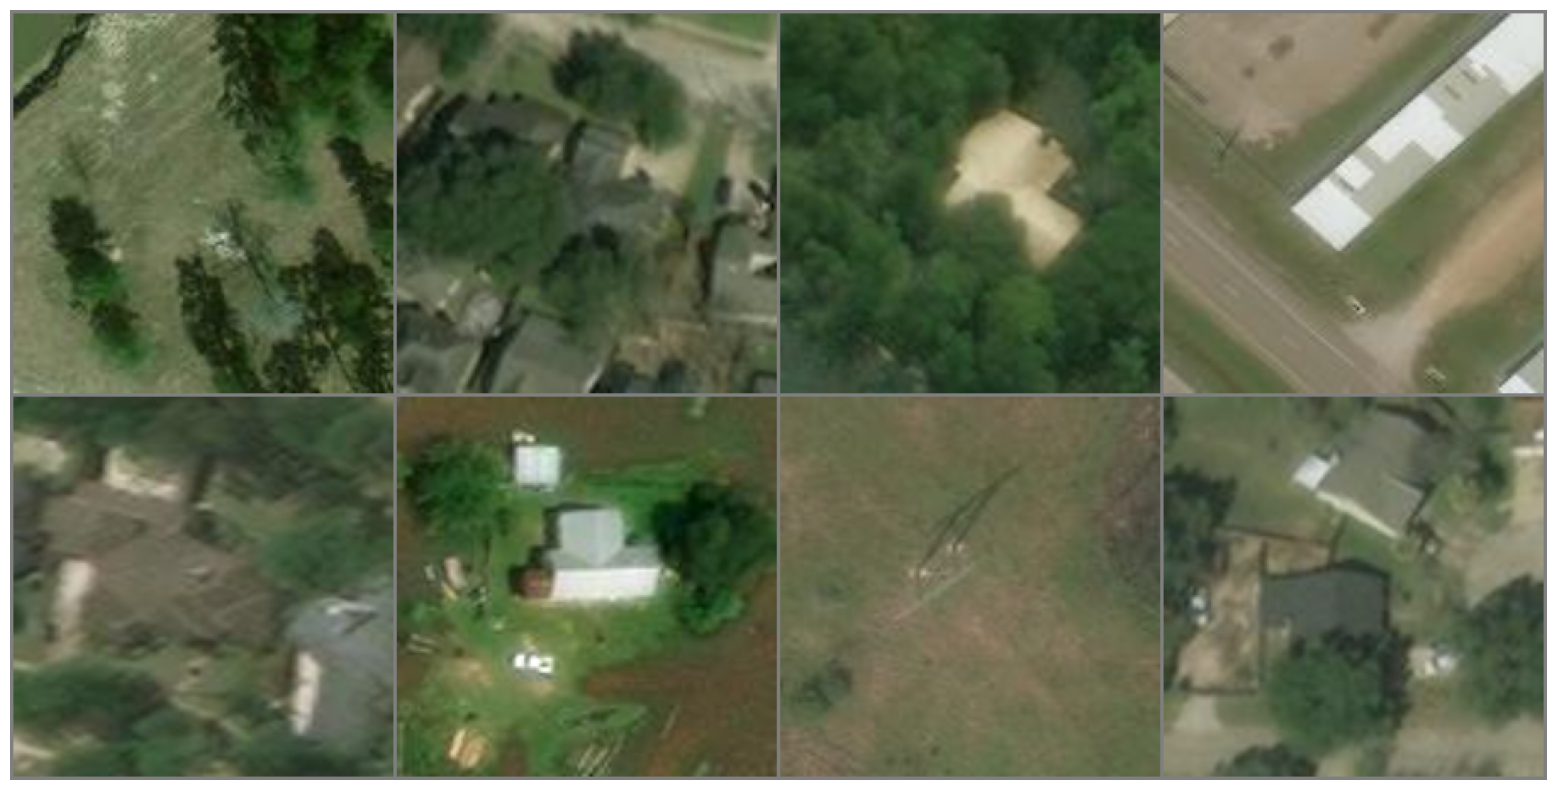

In [15]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, _ = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
imshow(make_grid(images[:8], nrow=4), size=(20, 10))

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class densenet169(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 32, 32),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(densenet169, self).__init__()
        # Initial convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [17]:
# 사전 학습된 densenet169 모델 불러오기
pretrained_densenet169 = models.densenet169(pretrained=True)
# 새로 정의한 모델 인스턴스 생성
net = densenet169(num_classes=1000)


# 사전 학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_densenet169.state_dict().keys())
# 사전 학습된 모델에서 커스텀 모델로 가중치 복사 시도
result = net.load_state_dict(pretrained_densenet169.state_dict(), strict=False)
# 복사 후 커스텀 모델의 features 부분에서 가중치 추출
custom_keys = set(net.state_dict().keys())


# 성공적으로 복사된 가중치 (커스텀 모델과 사전 학습된 모델 모두에 존재)
successfully_copied_keys = pretrained_keys.intersection(custom_keys)
# 커스텀 모델에 있지만 사전 학습된 모델에 없는 가중치
missing_keys = custom_keys - pretrained_keys
# 사전 학습된 모델에 있지만 커스텀 모델에 없는 가중치
unexpected_keys = pretrained_keys - custom_keys

print("성공적으로 복사된 가중치:", successfully_copied_keys)
print("커스텀 모델에는 있지만 사전 학습된 모델에는 없는 가중치 (누락):", result.missing_keys)
print("사전 학습된 모델에는 있지만 커스텀 모델에는 없는 가중치 (예상치 못한):", result.unexpected_keys) # net 모델에 없는데 pretrained_vgg19 가중치 파일에는 존재하는 항목의 이름이 리스트로 반환

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


성공적으로 복사된 가중치: {'features.denseblock2.denselayer1.conv2.weight', 'features.denseblock1.denselayer3.conv1.weight', 'features.denseblock2.denselayer1.norm1.num_batches_tracked', 'features.denseblock4.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.conv1.weight', 'features.denseblock4.denselayer22.norm2.running_mean', 'features.denseblock2.denselayer11.norm1.weight', 'features.denseblock3.denselayer30.conv2.weight', 'features.denseblock4.denselayer26.norm2.num_batches_tracked', 'features.denseblock2.denselayer5.norm2.num_batches_tracked', 'features.denseblock2.denselayer8.norm1.running_var', 'features.denseblock2.denselayer5.norm1.running_mean', 'features.denseblock4.denselayer11.norm2.num_batches_tracked', 'features.denseblock1.denselayer3.norm2.running_mean', 'features.denseblock4.denselayer31.norm2.weight', 'features.denseblock3.denselayer20.conv1.weight', 'features.denseblock3.denselayer3.conv2.weight', 'features.denseblock4.denselayer5.norm2.running_var', 'features.dense

In [18]:
print(net)

densenet169(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (r

In [19]:
# 모델의 모든 파라미터를 고정
for param in net.parameters():
    param.requires_grad = False

In [20]:
# classifier 부분의 가중치는 재학습을 위해 새로 정의
net.classifier = nn.Linear(1664, 1)

for param in net.classifier.parameters():
    param.requires_grad = True

net = net.to(device)

In [21]:
# 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [22]:
def validate_model(net, val_loader, criterion):
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [23]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        # tqdm을 사용하여 진행 상황 표시
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # 에폭 종료 후 로그 출력
        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [24]:
train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 369/369 [02:45<00:00,  2.23it/s]


[RAdam] Epoch 1, Train Loss: 0.671092, Val Loss: 0.643419, Validation Accuracy: 68.55%


Epoch 2/20: 100%|██████████| 369/369 [01:11<00:00,  5.17it/s]


[RAdam] Epoch 2, Train Loss: 0.620555, Val Loss: 0.582779, Validation Accuracy: 80.85%


Epoch 3/20: 100%|██████████| 369/369 [01:55<00:00,  3.19it/s]


[RAdam] Epoch 3, Train Loss: 0.564924, Val Loss: 0.524195, Validation Accuracy: 86.40%


Epoch 4/20: 100%|██████████| 369/369 [02:42<00:00,  2.27it/s] 


[RAdam] Epoch 4, Train Loss: 0.510704, Val Loss: 0.467981, Validation Accuracy: 88.90%


Epoch 5/20: 100%|██████████| 369/369 [01:04<00:00,  5.71it/s]


[RAdam] Epoch 5, Train Loss: 0.464735, Val Loss: 0.428538, Validation Accuracy: 89.50%


Epoch 6/20: 100%|██████████| 369/369 [01:05<00:00,  5.67it/s]


[RAdam] Epoch 6, Train Loss: 0.426976, Val Loss: 0.387194, Validation Accuracy: 90.35%


Epoch 7/20: 100%|██████████| 369/369 [01:04<00:00,  5.69it/s]


[RAdam] Epoch 7, Train Loss: 0.396847, Val Loss: 0.360221, Validation Accuracy: 90.45%


Epoch 8/20: 100%|██████████| 369/369 [01:05<00:00,  5.63it/s]


[RAdam] Epoch 8, Train Loss: 0.371820, Val Loss: 0.333772, Validation Accuracy: 90.75%


Epoch 9/20: 100%|██████████| 369/369 [01:05<00:00,  5.63it/s]


[RAdam] Epoch 9, Train Loss: 0.347679, Val Loss: 0.312483, Validation Accuracy: 91.25%


Epoch 10/20: 100%|██████████| 369/369 [01:05<00:00,  5.68it/s]


[RAdam] Epoch 10, Train Loss: 0.328036, Val Loss: 0.294516, Validation Accuracy: 91.30%


Epoch 11/20: 100%|██████████| 369/369 [01:05<00:00,  5.64it/s]


[RAdam] Epoch 11, Train Loss: 0.314275, Val Loss: 0.283540, Validation Accuracy: 91.25%


Epoch 12/20: 100%|██████████| 369/369 [01:04<00:00,  5.69it/s]


[RAdam] Epoch 12, Train Loss: 0.300118, Val Loss: 0.269839, Validation Accuracy: 92.00%


Epoch 13/20: 100%|██████████| 369/369 [01:04<00:00,  5.69it/s]


[RAdam] Epoch 13, Train Loss: 0.293200, Val Loss: 0.256275, Validation Accuracy: 92.05%


Epoch 14/20: 100%|██████████| 369/369 [01:04<00:00,  5.70it/s]


[RAdam] Epoch 14, Train Loss: 0.281199, Val Loss: 0.252312, Validation Accuracy: 91.75%


Epoch 15/20: 100%|██████████| 369/369 [01:04<00:00,  5.75it/s]


[RAdam] Epoch 15, Train Loss: 0.272408, Val Loss: 0.243877, Validation Accuracy: 92.05%


Epoch 16/20: 100%|██████████| 369/369 [01:06<00:00,  5.51it/s]


[RAdam] Epoch 16, Train Loss: 0.264363, Val Loss: 0.237003, Validation Accuracy: 92.05%


Epoch 17/20: 100%|██████████| 369/369 [01:05<00:00,  5.65it/s]


[RAdam] Epoch 17, Train Loss: 0.259231, Val Loss: 0.230511, Validation Accuracy: 92.60%


Epoch 18/20: 100%|██████████| 369/369 [01:04<00:00,  5.71it/s]


[RAdam] Epoch 18, Train Loss: 0.250504, Val Loss: 0.225483, Validation Accuracy: 92.35%


Epoch 19/20: 100%|██████████| 369/369 [01:05<00:00,  5.65it/s]


[RAdam] Epoch 19, Train Loss: 0.246449, Val Loss: 0.221781, Validation Accuracy: 92.35%


Epoch 20/20: 100%|██████████| 369/369 [01:05<00:00,  5.64it/s]


[RAdam] Epoch 20, Train Loss: 0.238338, Val Loss: 0.216437, Validation Accuracy: 92.40%


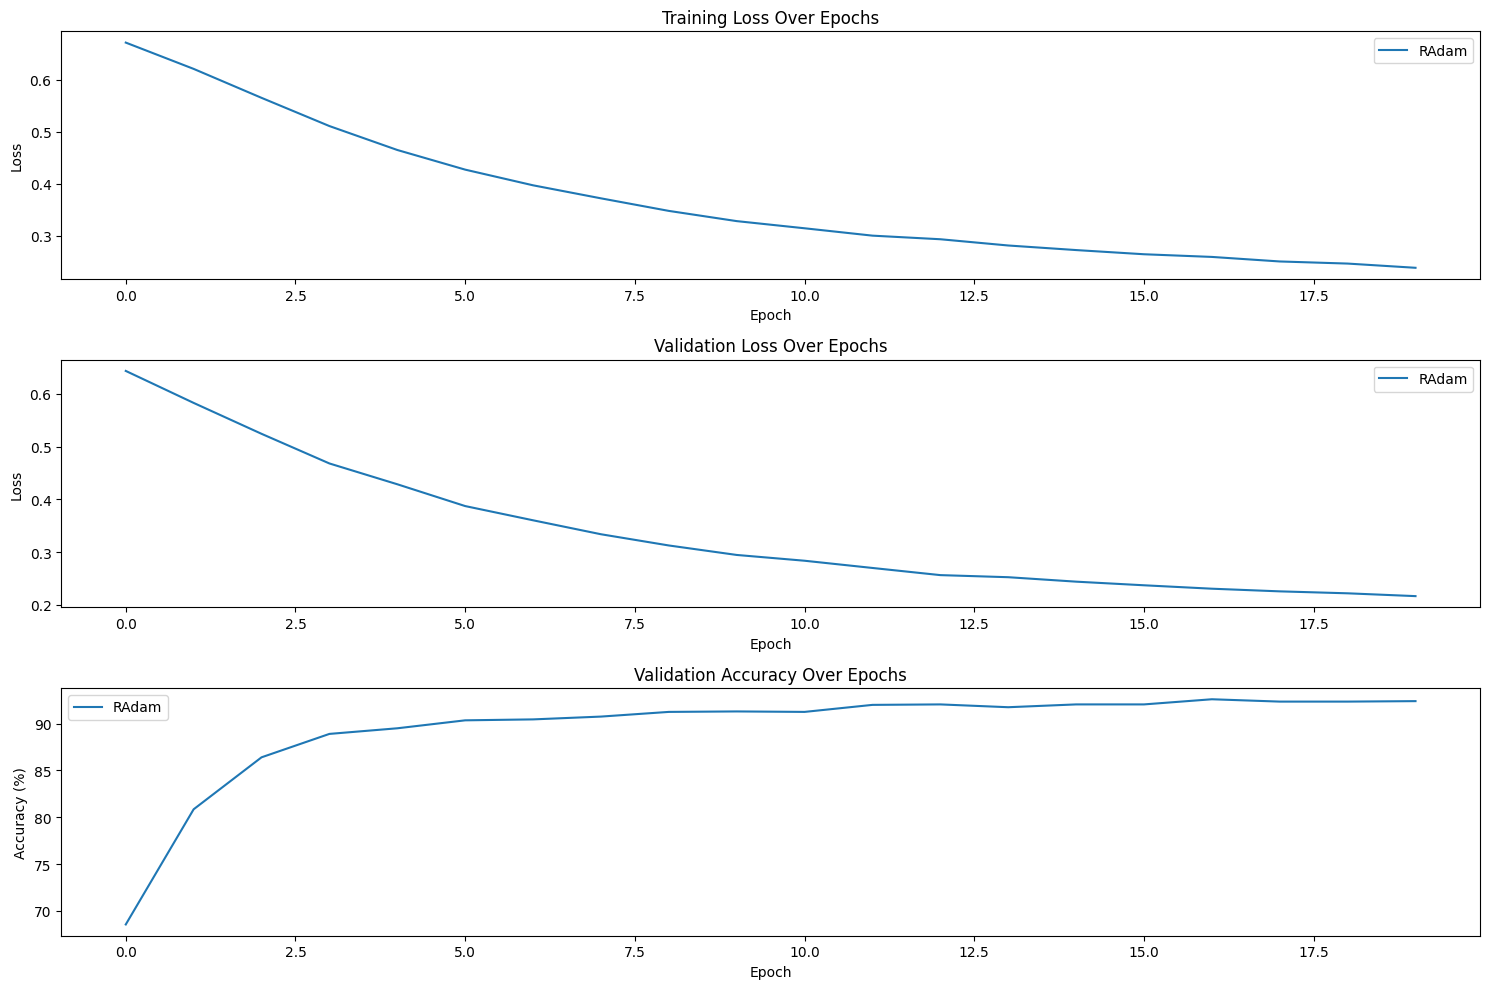

In [25]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

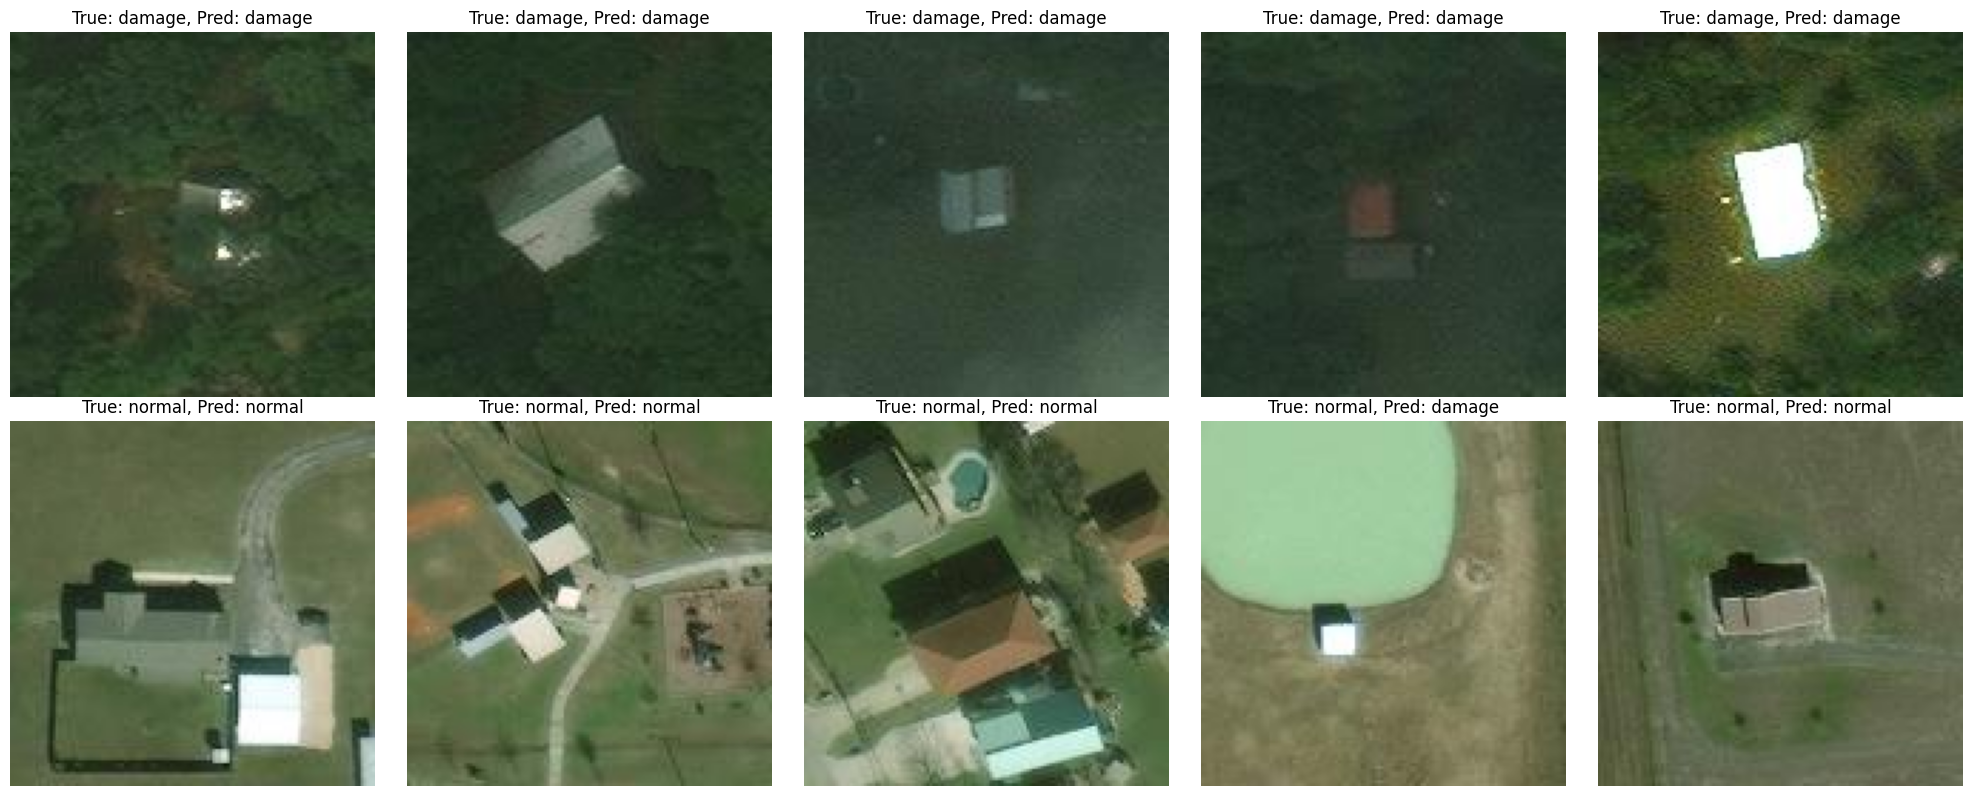

In [27]:
class_folders = {
    'damage': '../실습 파일/9/test/damage',
    'normal': '../실습 파일/9/test/normal'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        net.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = net(image)
            # 시그모이드 함수 적용하여 확률 얻기
            probs = torch.sigmoid(outputs).item()
            prediction = 'normal' if probs >= 0.5 else 'damage'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'normal' else 0)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

In [29]:
# Evaluate models
densenet_metrics = evaluate_model(net, class_folders, pytorch_transforms)

# Print comparison
print("densenet Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*densenet_metrics))

densenet Metrics: Accuracy: 0.9600, Precision: 0.9694, Recall: 0.9500, F1: 0.9596
